In [37]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [38]:
df_engine = pd.read_csv('engine_data.csv')

In [39]:
df_engine.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [40]:
df_engine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


The engine condition column must be changed to category.

In [41]:
df_engine['Engine Condition'] = df_engine['Engine Condition'].astype('category')

In [42]:
df_engine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Engine rpm        19535 non-null  int64   
 1   Lub oil pressure  19535 non-null  float64 
 2   Fuel pressure     19535 non-null  float64 
 3   Coolant pressure  19535 non-null  float64 
 4   lub oil temp      19535 non-null  float64 
 5   Coolant temp      19535 non-null  float64 
 6   Engine Condition  19535 non-null  category
dtypes: category(1), float64(5), int64(1)
memory usage: 935.0 KB


In [43]:
df_engine.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912


# Exploratory Data Analysis

Performing univariate analysis on the data to understand the distribution of values for a single variable. 

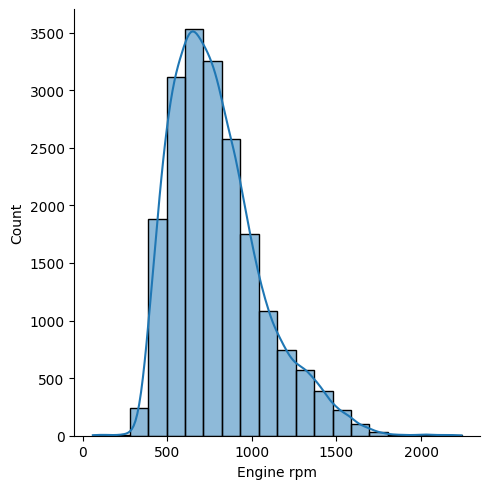

In [44]:
sns.displot(data=df_engine['Engine rpm'], bins= 20, kde= True)
plt.show()

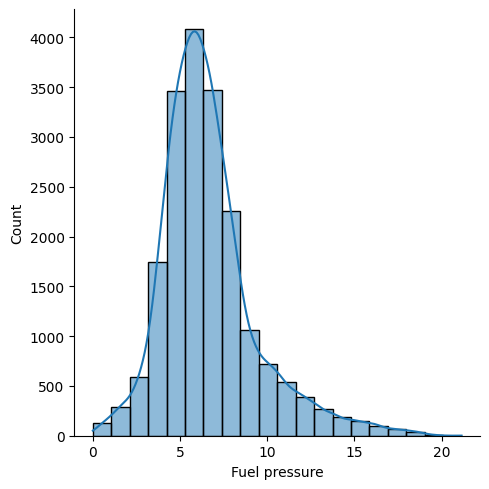

In [45]:
sns.displot(data=df_engine['Fuel pressure'], bins= 20, kde= True)
plt.show()

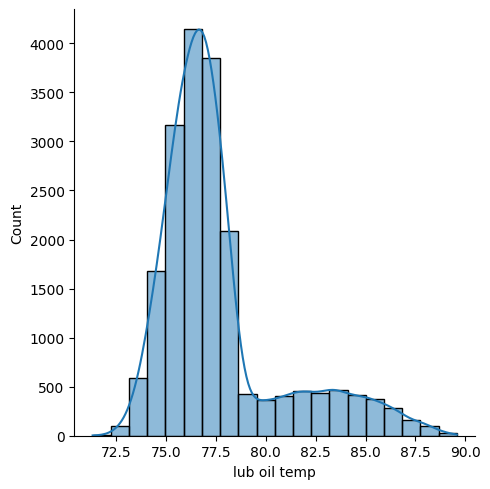

In [46]:
sns.displot(data=df_engine['lub oil temp'], bins= 20, kde= True)
plt.show()

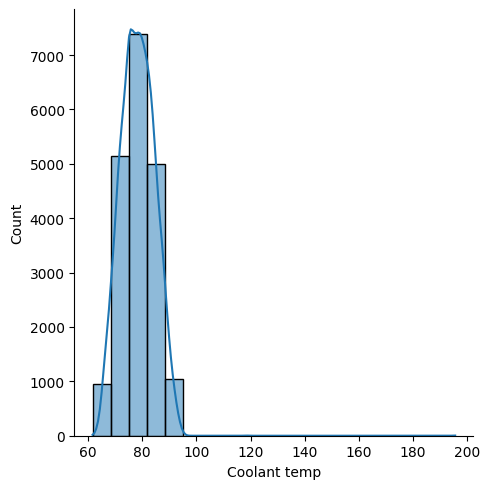

In [47]:
sns.displot(data=df_engine['Coolant temp'], bins= 20, kde= True)
plt.show()

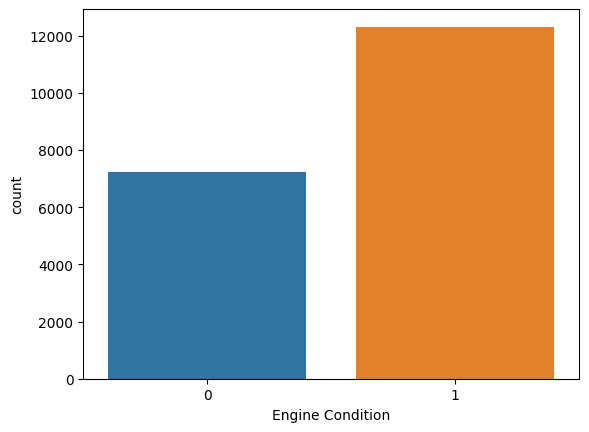

In [48]:
sns.countplot(x=df_engine['Engine Condition'])
plt.show()

There is imbalance in the Engine Condition. To handle the imbalance we can use resampling techniques, adjust the class weights or collect more data. For this code since we are using a dataset from Kaggle we cannot collect more data, hence working on the same dataset. But this might lead to a lower accuracy score.

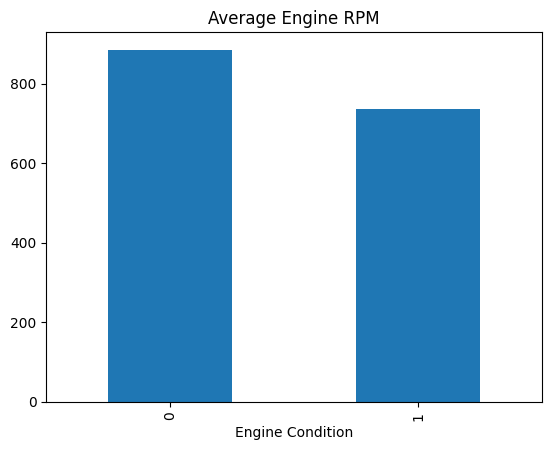

In [49]:
df_engine.groupby('Engine Condition')['Engine rpm'].mean().plot(kind='bar')
plt.title('Average Engine RPM')
plt.show()

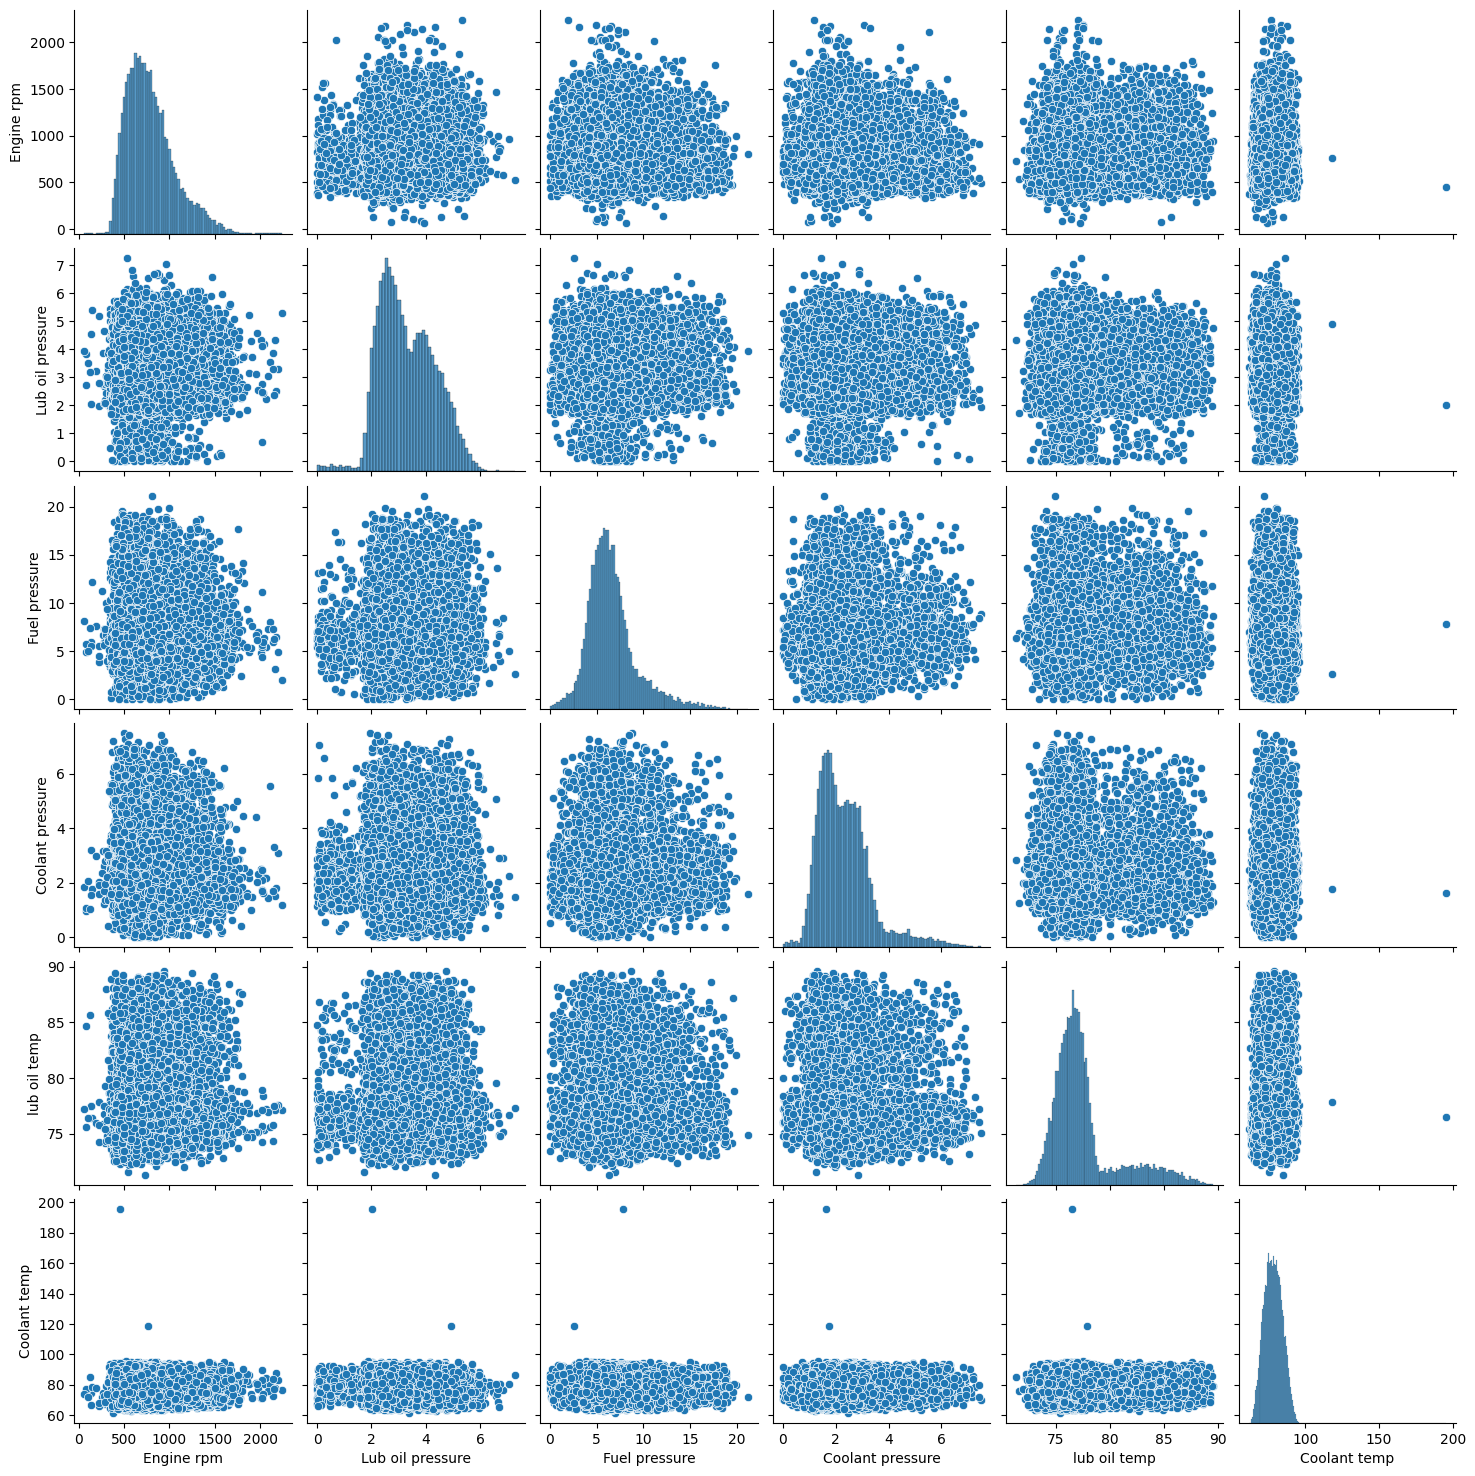

In [50]:
sns.pairplot(df_engine)

C:\Users\suman\AppData\Local\Temp\ipykernel_11720\1407956728.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_engine.corr(), annot=True)


<AxesSubplot: >

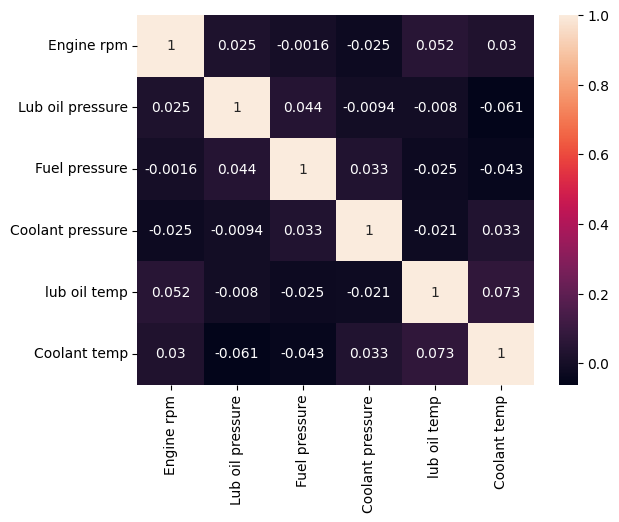

In [51]:
sns.heatmap(df_engine.corr(), annot=True)

# Feature Engineering

<AxesSubplot: >

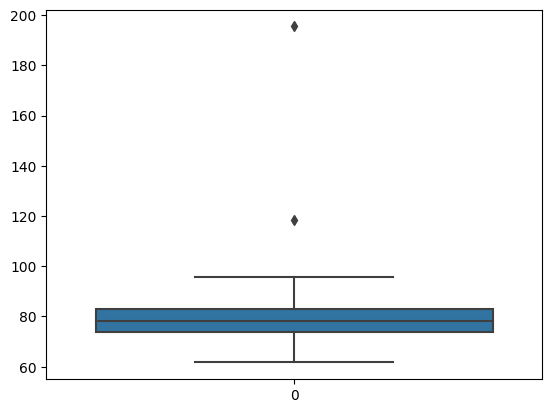

In [52]:
sns.boxplot(df_engine['Coolant temp'])

<AxesSubplot: >

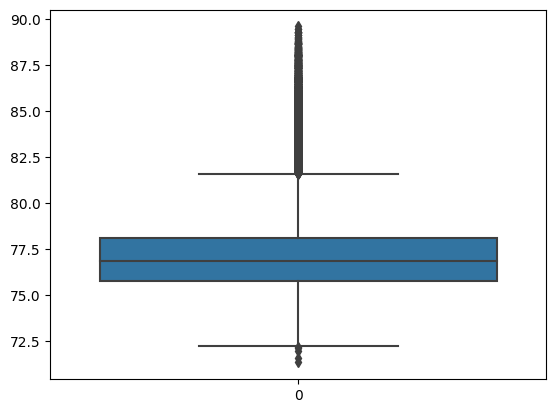

In [53]:
sns.boxplot(df_engine['lub oil temp'])

<AxesSubplot: >

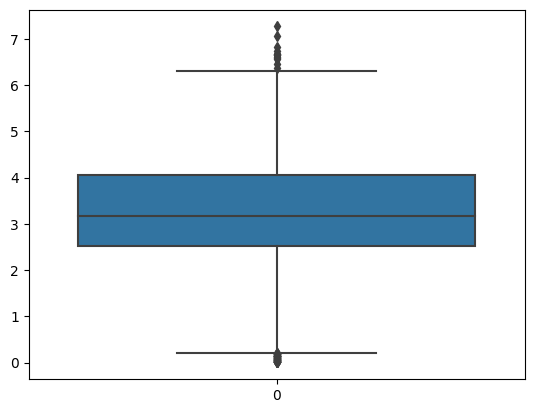

In [54]:
sns.boxplot(df_engine['Lub oil pressure'])

<AxesSubplot: >

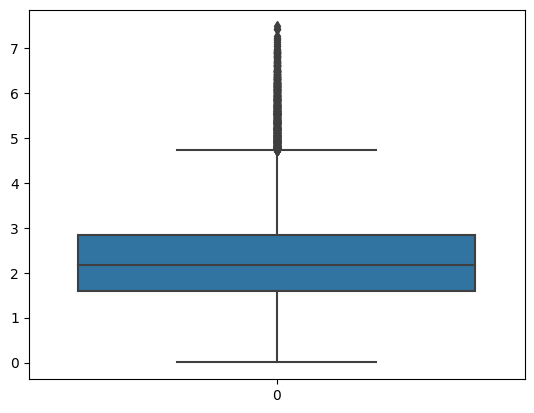

In [55]:
sns.boxplot(df_engine['Coolant pressure'])

As observable, there are many outliers in the data. We will do an outlier analysis using Z score for the coolant temp column and IQR method for the rest. Lets check the no. of outliers in each column

In [56]:
for i in ['Engine rpm', 'Lub oil pressure','Fuel pressure', 'Coolant pressure','lub oil temp']:
    percentile25 = df_engine[i].quantile(0.25)
    percentile75 = df_engine[i].quantile(0.75)

    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    oulier_count=len(df_engine[df_engine[i]>upper_limit])+len(df_engine[df_engine[i]<lower_limit])
    print("The no. of outliers in", i, 'is', oulier_count)
    df_engine[i] = np.where(
    df_engine[i] > upper_limit, upper_limit, np.where( df_engine[i] < lower_limit, lower_limit, df_engine[i]))

The no. of outliers in Engine rpm is 464
The no. of outliers in Lub oil pressure is 66
The no. of outliers in Fuel pressure is 1135
The no. of outliers in Coolant pressure is 785
The no. of outliers in lub oil temp is 2617


In [57]:
upper_limit_cooltemp = df_engine['Coolant temp'].mean() + 3*df_engine['Coolant temp'].std()
lower_limit_cooltemp = df_engine['Coolant temp'].mean() - 3*df_engine['Coolant temp'].std()
df_engine['Coolant temp'] = np.where(
    df_engine['Coolant temp']>upper_limit_cooltemp,
    upper_limit_cooltemp,
    np.where(
        df_engine['Coolant temp']<lower_limit_cooltemp,
        lower_limit_cooltemp,
        df_engine['Coolant temp']
    )
)

<AxesSubplot: >

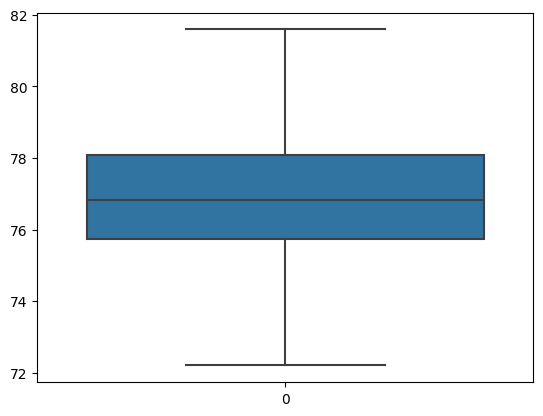

In [58]:
sns.boxplot(df_engine['lub oil temp'])

<AxesSubplot: >

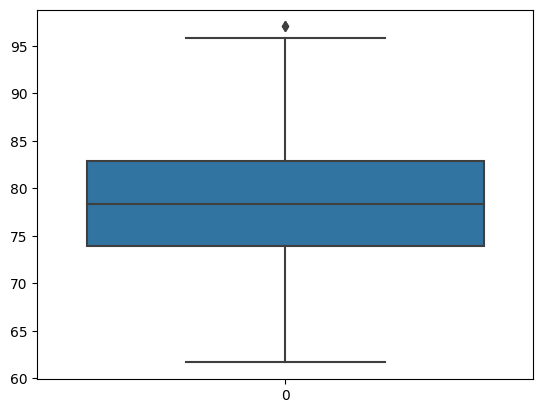

In [59]:
sns.boxplot(df_engine['Coolant temp'])

<AxesSubplot: >

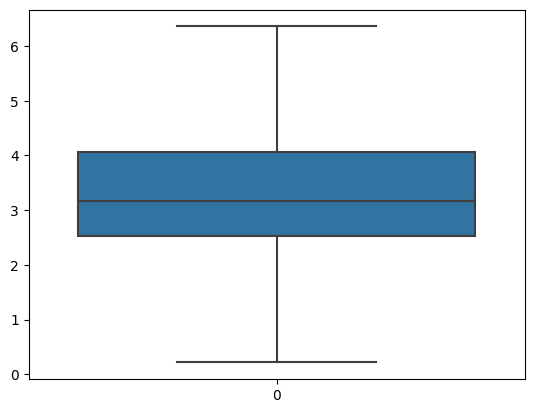

In [60]:
sns.boxplot(df_engine['Lub oil pressure'])

## Scaling and transforming data

In [61]:
X = df_engine.drop(['Engine Condition'], axis=1)
Y = df_engine['Engine Condition']

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, test_size = 0.25)
x_train.shape, x_test.shape

((14651, 6), (4884, 6))

In [63]:
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

In [64]:
x_train_scaled[0:5]

array([[-0.22239222, -2.7488954 ,  0.29187198,  0.30050099, -0.47063203,
        -1.1585091 ],
       [ 1.05580517,  1.43100116, -0.03576588,  0.54098826, -1.16842008,
        -1.06111234],
       [-0.28436543, -0.73148714,  0.12720982, -0.67954471,  0.04907308,
         0.72943356],
       [ 0.38571987, -1.07324799, -1.07598605,  0.51824331,  1.90840975,
         1.65176987],
       [-1.11325707,  0.36352408, -1.00524377, -1.54645915,  0.05501233,
        -0.0969859 ]])

In [65]:
x_train_scaled=pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled=pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [66]:
x_train_scaled.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,-0.222392,-2.748895,0.291872,0.300501,-0.470632,-1.158509
1,1.055805,1.431001,-0.035766,0.540988,-1.168420,-1.061112
2,-0.284365,-0.731487,0.127210,-0.679545,0.049073,0.729434
3,0.385720,-1.073248,-1.075986,0.518243,1.908410,1.651770
4,-1.113257,0.363524,-1.005244,-1.546459,0.055012,-0.096986


## Model Training and Evaluation

LogisticRegression

In [67]:
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train)
y_pred_LR = LR_model.predict(x_test_scaled)

print("LogisticRegression \n")
print('Accuracy Score: {}'.format((accuracy_score(y_test, y_pred_LR) * 100)))

F1_score = metrics.f1_score(y_test, y_pred_LR)
print("F1 Score:",F1_score)

LogisticRegression 

Accuracy Score: 65.06961506961507
F1 Score: 0.7564944333428489


RandomForestClassifier

In [68]:
RFC_model = RandomForestClassifier()
RFC_model.fit(x_train_scaled, y_train)
y_pred_RFC = RFC_model.predict(x_test_scaled)

print("Random Forest Classifier \n")
print('Accuracy Score: {}'.format((accuracy_score(y_test, y_pred_RFC) * 100)))

F1_score = metrics.f1_score(y_test, y_pred_RFC)
print("F1 Score:",F1_score)

Random Forest Classifier 

Accuracy Score: 64.78296478296478
F1 Score: 0.7407295749170938


In [69]:
# Hyperparameter tuning
RFC2_model = RandomForestClassifier(criterion= 'entropy', max_depth= 8, min_samples_split= 2, n_estimators= 150)
RFC2_model.fit(x_train_scaled, y_train)
y_pred_RFC2 = RFC2_model.predict(x_test_scaled)

print("RFC Hyperparameter tuning")
print('Accuracy Score: {}'.format((accuracy_score(y_test, y_pred_RFC2) * 100)))

F1_score = metrics.f1_score(y_test, y_pred_RFC2)
print("F1 Score:",F1_score)

RFC Hyperparameter tuning
Accuracy Score: 66.21621621621621
F1 Score: 0.7622478386167146


In [70]:
cm = confusion_matrix(y_test, y_pred_RFC2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[False, True])

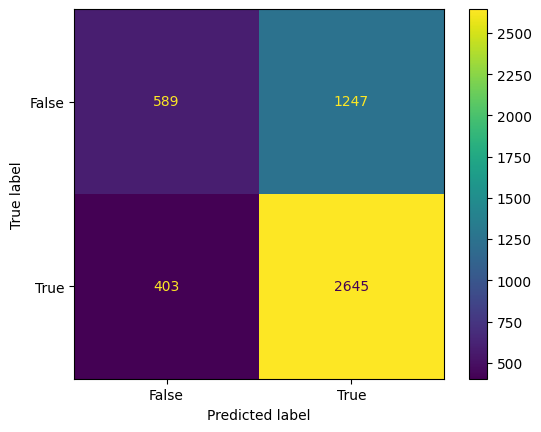

In [71]:
disp.plot()
plt.show()